In [1]:
!nvidia-smi

Fri Feb 21 19:55:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import pandas as pd
import numpy as np
from timeit import timeit as time
import cupy as cp
from  cupy.linalg import pinv as pinv2

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [3]:
selected_features = ["TP2", "H1", "DV_pressure", "Reservoirs", "Oil_temperature", "Motor_current", "Oil_level", 'status']

In [4]:
data = pd.read_csv("Clean_Data.csv")
data.head()

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,status
0,562564,2020-04-18 00:00:01,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
1,562565,2020-04-18 00:00:13,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
2,562566,2020-04-18 00:00:24,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1
3,562567,2020-04-18 00:00:36,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,562568,2020-04-18 00:00:49,-0.018,8.248,8.238,-0.024,8.248,49.45,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1


In [5]:
# Choose only features selected from Question 2
#Shuffle the data
data = data.sample(frac = 1)
data.head()

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,status
18450,898243,2020-06-06 06:28:04,7.332,8.148,-0.008,1.876,8.150,75.675,5.3600,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1
23480,903362,2020-06-07 00:20:44,8.148,7.956,-0.010,2.110,7.960,75.375,5.5150,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1
16768,896561,2020-06-06 01:50:11,6.174,8.186,-0.008,1.496,8.188,75.300,5.0850,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1
6612,569176,2020-04-18 18:21:17,8.940,8.838,-0.004,1.986,8.840,73.700,5.6675,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1
39654,741714,2020-05-15 05:54:23,-0.014,9.220,9.206,-0.024,9.218,56.700,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0


In [6]:
X = data[selected_features]
y = data['status']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:

onehotencoder = OneHotEncoder(categories='auto')
scaler = StandardScaler()

# Convert y_train and y_test to numpy arrays first
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = scaler.fit_transform(X_train)
y_train = onehotencoder.fit_transform(y_train[:, np.newaxis]).toarray()

X_test = scaler.transform(X_test)
y_test = onehotencoder.transform(y_test[:, np.newaxis]).toarray()


### 1. Extreme Learning Machine

* Extreme Learning Machine is a variation of Feed forward neural network with just 1 hidden layer.
* Extreme Machine Learning does not use iterative method such as gradient descent to tuning the weights, instead it use linear algebra to solve for the optimal solution.
* Extreme Machine Learning is believed to be able to approximate any abitrary function given sufficient number of hidden units and data to learn.

In [9]:
#Tranfer data to GPU:
X_train_gpu = cp.asarray(X_train)
y_train_gpu = cp.asarray(y_train)

X_test_gpu = cp.asarray(X_test)
y_test_gpu = cp.asarray(y_test)

In [10]:
#this Extreme Machine Learning class is implemented specificly to work on GPU
#this will not run on a CPU machine

class ExtremeLearningMachine():
  def __init__(self, hidden_size = 10, threshold = 0.5):
    self._hidden_size = hidden_size
    self._input_size  = None
    self._w = None
    self._b = None
    self._beta = None
    self._threshold = 0.5

  def _h(self,x):
    return self._tanh(cp.dot(x, self._w) + self._b )

  @property
  def hidden_size(self):
    return self._hidden_size

  @staticmethod
  def _tanh(x):
    return cp.tanh(x)

  def fit(self, x, y):
    self._input_size = x.shape[1]
    self._w = cp.random.normal( size = [self._input_size, self._hidden_size])
    self._b = cp.random.normal(size = [self._hidden_size])

    H = self._h(x)
    self._beta = cp.dot(pinv2(H), y)

  def predict(self, x):
    out = cp.dot(self._h(x), self._beta)
    return out

In [11]:
num_hidden = [5,10,20,30,40,50,60,70]
scores = []

for h in num_hidden:
  elm = ExtremeLearningMachine(h)
  elm.fit(X_train_gpu, y_train_gpu)
  y_pred_gpu = elm.predict(X_test_gpu)

  #Convert data back to cpu
  y_pred = cp.asnumpy(y_pred_gpu)
  y_test = cp.asnumpy(y_test_gpu)

  y_pred = np.argmax(y_pred, axis = 1)
  y_test = np.argmax(y_test, axis = 1)
  scores.append(accuracy_score(y_test, y_pred))
  #Clear GPU memmory
  del elm
  cp._default_memory_pool.free_all_blocks()

In [12]:
best_hidden_size_indx = np.argmax(scores)
best_hidden_size = num_hidden[best_hidden_size_indx]
best_score       = scores[best_hidden_size_indx]

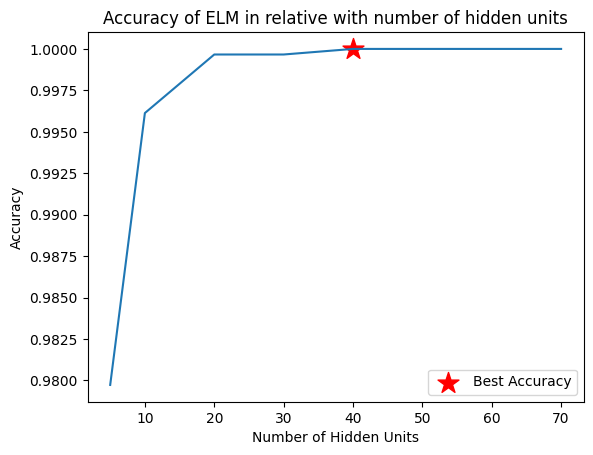

In [13]:
plt.plot(num_hidden, scores)
plt.scatter(best_hidden_size, best_score, s = 250, marker = "*", color = 'r' , label = 'Best Accuracy')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Accuracy')
plt.title('Accuracy of ELM in relative with number of hidden units' )
plt.legend()
plt.show()

In [14]:
elm = ExtremeLearningMachine(best_hidden_size)
elm.fit(X_train_gpu, y_train_gpu)

In [15]:
y_pred_gpu = elm.predict(X_test_gpu)

Best result achieved with 40 hidden units
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6044
           1       1.00      1.00      1.00      5845

    accuracy                           1.00     11889
   macro avg       1.00      1.00      1.00     11889
weighted avg       1.00      1.00      1.00     11889



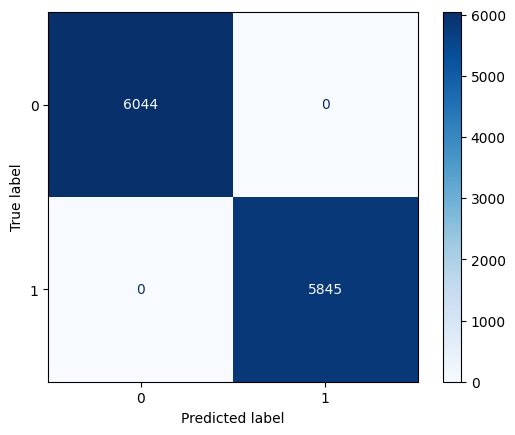

In [16]:
#Convert data back to cpu
y_pred = cp.asnumpy(y_pred_gpu)
y_test = cp.asnumpy(y_test_gpu)

y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

print(f'Best result achieved with {elm.hidden_size} hidden units')
print(classification_report(y_test, y_pred))
c_mat  = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(c_mat, display_labels=['0', '1'])
disp.plot(cmap='Blues', values_format='d')
plt.show()

In [17]:
#Clear GPU memmory
del X_train_gpu
del y_train_gpu
del X_test_gpu
del y_test_gpu
cp._default_memory_pool.free_all_blocks()